## Weblog Analysis

Install all the required packages and libraries.

In [1]:
!pip install -r requirements.txt

In [2]:
import os
# import pandas
import pandas as pd
# import seaborn plotter
import seaborn as sns
sns.set()
# import matlib plots
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# import spark libs
import pyspark
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, TimestampType

## Liten
Liten democratizes data for easy use of AI and analytics.

#### Session
Liten session contains all the information required to do all the work.

#### Database
Liten stores unlimited both sql and AI data in an object delta store. All data are stored in Liten tensor format. This improves query performance by 10-100x enabling real time interactive queries.

In [3]:
import liten
ten = liten.Session()
ten.load_local_demofiles()
spark = ten.spark


### Query

Liten provides semantic query with structured SQL support. It uses spark query engine for SQL analytics, and OpenAI with prompt engineering.

### Web log File Example


For looking at weblog file, we will load and analyze a sample file. In this sample log file, these are the fields present. 

Field | Description                            |
------|----------------------------------------|
IP    | Remote host IP number                  |
Time  | Time at which the request was sent     |
URL   | A Restfule request like GET, POST etc. |
Status| Status response for the request        |

Read a sample weblog file.
The log files are already loaded in the database. One can also load it with a command similar to the following.
```
weblog_schema = StructType([ \
    StructField("IP",StringType(),True), \
    StructField("Time",TimestampType(),True), \
    StructField("URL",StringType(),True), \
    StructField("Status", IntegerType(), True)
                           ])
weblog_df = ten.spark.read.format('csv').options(header='true').options(delimiter=',').options(timestampFormat='dd/MMM/yyyy:HH:mm:ss').schema(weblog_schema).load("weblog.csv")
weblog_df.createOrReplaceTempView("weblog")
weblog_df.printSchema()
weblog_df.take(5)
```

Use SQL query to see the number of log file. Look at redirection messages if any.

In [4]:
print(f"Total number of log lines")
cntDf = ten.spark.sql("select count(*) from weblog")
cntDf.show()
print(f"Request counts which were redirected")
st3xxDf = ten.spark.sql("SELECT Status, COUNT(*) FROM weblog WHERE Status LIKE '3%%' GROUP BY Status")
st3xxDf.show()

Total number of log lines
+--------+
|count(1)|
+--------+
|   15964|
+--------+

Request counts which were redirected
+------+--------+
|Status|count(1)|
+------+--------+
|   304|     658|
|   302|    3498|
+------+--------+



Plot number of weblog requests before 2021 on a horizontal timeseries plot.

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


Datatypes
ip                object
time      datetime64[ns]
url               object
status             int32
dtype: object
Summary
ip        15
time      15
url       15
status    15
dtype: int64
Samples
            ip                time                               url  status
11  10.130.2.1 2017-11-29 07:00:19           GET /login.php HTTP/1.1     200
1   10.128.2.1 2017-11-29 06:59:02        POST /process.php HTTP/1.1     302
8   10.131.2.1 2017-11-29 06:59:30  GET /edit.php?name=bala HTTP/1.1     200


<Axes: xlabel='time'>

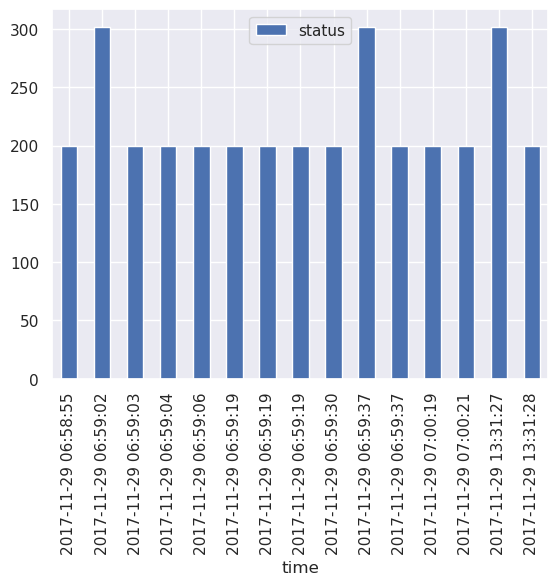

In [7]:
st17Df = ten.spark.sql("SELECT * FROM weblog WHERE Time <= '2021-12-31' limit 15")
df = st17Df.toPandas()
print(f"\033[1mDatatypes\033[0m\n{df.dtypes}\n\033[1mSummary\033[0m\n{df.count()}\n\033[1mSamples\033[0m\n{df.sample(3)}")
df.plot.bar(y='status', x='time')

Start a new debug query. Understand possible mistakes made in weblog files.

In [8]:
ten.ask("Weblog is a log file generated by servers. Can you explain its different fields? Please list top three errors which has maximum impact on reliability.")

Weblog is a file that contains a record of all the requests made to a server. It includes various fields that provide information about each request, such as the date and time of the request, the IP address of the client, the URL requested, the HTTP status code, and more.

The top three errors that have the maximum impact on reliability are:

1. 404 Not Found Error: This error occurs when a requested resource is not found on the server. It can happen due to various reasons like incorrect URL, deleted file, or broken link. It can negatively impact the user experience and can result in a loss of traffic.

2. 500 Internal Server Error: This error occurs when the server encounters an unexpected condition that prevents it from fulfilling the request. It can happen due to various reasons like misconfigured server settings, database errors, or coding errors. It can negatively impact the user experience and can result in a loss of traffic.

3. 503 Service Unavailable Error: This error occurs w

List all  404 errors. See how many occured.

In [9]:
ten.codegen("Count number of rows from weblog table where Status column has 404 errors")

```SQL
SELECT COUNT(*) FROM weblog WHERE Status = '404';
```

In [10]:
df=ten.spark.sql("""
SELECT COUNT(*) FROM weblog WHERE Status = '404';
""")
df.show()

+--------+
|count(1)|
+--------+
|     251|
+--------+



Connection timed out errors. See if they are in the log file.

In [11]:
ten.codegen("Find number of rows from weblog table where Status column is equal to  http status code for request timeout")

Here's the SQL code for the given description:

```SQL
SELECT COUNT(*) FROM weblog WHERE Status = '408 Request Timeout';
``` 

This query selects the count of all rows from the `weblog` table where the `Status` column is equal to the HTTP status code for request timeout, which is `408`.

In [12]:
df=ten.spark.sql("""
SELECT COUNT(*) 
FROM weblog 
WHERE Status = '408';
""")
df.show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



In [ ]:
ten.codegen("Select all rows whre Status column is in 300,400,2030 from weblog table from last 3 hours")

In [ ]:
df=ten.spark.sql("""
SELECT *
FROM weblog
WHERE Status IN (300, 400, 2030)
AND Time >= DATEADD(hour, -3, GETDATE())
""")
df.show()

### Expert AI Agents
Liten stores all work in AI memory. Liten uses domain specific data and knowledge including all work done using Liten to fine-tune, train and create AI agents.
Engineers can query these agents or chat with them.

Liten AI Agents are your domain data expert that you can query or chat for various things 
* Execute a query described in text
* Ask interesting questions about the data e.g. any redirections have happened or if server went down
* Execute a general tasks

Currently comes pre-packaged with AI & SQL agents for typical data files like apache webserver logs, weblog files etc. We can also create agents for other domain areas.

Customer generated work and associated models are all owned by customers. Liten helps create the model and AI agents optimized for customer needs.

In [13]:
agent = ten.agent('weblog')

In [14]:
agent.summarize()

Workitem 0: The given text is only showing a single input command, which installs the required packages by running "!pip install -r requirements.txt" in a Python notebook. There is no output provided for this command.

Workitem 1: The given text is a list of input commands in Python, including imports and defining a session and agent. However, there is no output provided.



In [15]:
agent.find_similar("Find the work item where request timeout is queried")

The work closest to the given summary is:

Work 2 = The given text is a Python code snippet that sets a request timeout of 5 seconds for an API call using the requests library. The code then makes the API call and prints the response.


In [18]:
agent.replay(1)

In [ ]:
ten.codegen("Select rows from weblog table where Status column is equal to  http status code for resource not found")

In [23]:
df=ten.spark.sql("""
SELECT *
FROM weblog
WHERE Status = '404';
""")
df.show()

+----------+-------------------+--------------------+------+
|        ip|               time|                 url|status|
+----------+-------------------+--------------------+------+
|10.131.0.1|2017-11-29 19:22:12|GET /robots.txt H...|   404|
|10.130.2.1|2017-11-30 07:24:34|GET /robots.txt H...|   404|
|10.131.0.1|2017-11-30 07:26:06|GET /robots.txt H...|   404|
|10.130.2.1|2017-11-30 08:08:51|GET /robots.txt H...|   404|
|10.128.2.1|2017-11-30 08:47:05|GET /favicon.ico ...|   404|
|10.130.2.1|2017-11-30 14:37:22|GET /favicon.ico ...|   404|
|10.128.2.1|2017-11-30 15:21:02|GET /favicon.ico ...|   404|
|10.129.2.1|2017-11-30 16:17:16|GET /robots.txt H...|   404|
|10.130.2.1|2017-11-30 16:17:16|GET /robots.txt H...|   404|
|10.131.0.1|2017-11-30 19:47:30|GET /robots.txt H...|   404|
|10.131.2.1|2017-11-30 20:06:56|GET /favicon.ico ...|   404|
|10.128.2.1|2017-11-30 20:33:50|GET /robots.txt H...|   404|
|10.131.2.1|2017-11-30 20:33:51|GET /robots.txt H...|   404|
|10.131.2.1|2017-12-01 0

In [20]:
agent.analyze(df,'based on the provided data, can you tell why 404 status response came. 404 means that the data was not found.')

Based on the provided data, it is not possible to determine why the 404 status response came. The data only shows that requests were made for certain files (such as /robots.txt and /favicon.ico) but the reason for the files not being found cannot be determined from this data alone.


In [24]:
agent.analyze(df,'based on the provided data, can you tell me if a patterm exists when we get 404 status response. I am looking for times of daya when this occurs mostly.')

Based on the provided data, there does seem to be a pattern when a 404 status response occurs. The majority of the 404 responses seem to occur during the daytime hours, specifically between 7am and 9pm. There are a few instances of 404 responses occurring in the early morning or late at night, but these are much less frequent.


/usr/local/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


Datatypes
ip                object
time      datetime64[ns]
url               object
status             int32
dtype: object
Summary
ip        251
time      251
url       251
status    251
dtype: int64
Samples
             ip                time                        url  status
37   10.129.2.1 2017-11-11 10:33:18   GET /robots.txt HTTP/1.1     404
15   10.129.2.1 2017-12-01 22:08:38  GET /favicon.ico HTTP/1.1     404
208  10.128.2.1 2018-01-17 02:33:57   GET /robots.txt HTTP/1.1     404


<Axes: xlabel='time'>

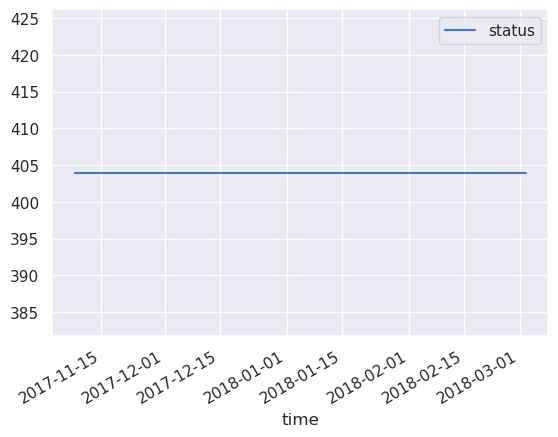

In [27]:
pdf = df.toPandas()
print(f"\033[1mDatatypes\033[0m\n{pdf.dtypes}\n\033[1mSummary\033[0m\n{pdf.count()}\n\033[1mSamples\033[0m\n{pdf.sample(3)}")
pdf.plot.line(y='status', x='time')

In [21]:
df=ten.spark.sql("""
SELECT *
FROM weblog
limit 200
""")
ten.plot(df)

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


hvDataFrameExplorer(axes=Axes(explorer=..., height=None, legend='right', logx=False, logy=False, name='Axes00821', responsive=False, shared_axes=True, width=None, xlim=None, ylim=None), by=[], colormapping=Colormapping(clim=None, cmap='kbc_r', cnorm='linear', color=None, colorbar=None, explorer=..., name='Colormapping00881', rescale_discrete_levels=True, symmetric=False), groupby=[], kind='line', labels=Labels(clabel='', explorer=..., fontscale=1, name='Labels00928', rot=0, title='', xlabel='', ylabel=''), name='hvDataFrameExplorer00788', operations=Operations(aggregator=None, datashade=False, dynspread=False, explorer=..., name='Operations00972', rasterize=False, x_sampling=None, y_sampling=None), style=Style(alpha=1, explorer=..., name='Style01016'), x='index', y='ip', y_multi=[], z=None)